In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import os
import subprocess
import statsmodels.formula.api as smf

import pysal as ps

import pylab as pl
%pylab inline

# make sure we are at the top of the repo
wd = subprocess.check_output('git rev-parse --show-toplevel', shell = True)
os.chdir(wd[:-1]) #-1 removes \n

Populating the interactive namespace from numpy and matplotlib


### Set up the data

In [2]:
# read in cleaned data
df = gp.read_file('data/citi_stations_new/citi_stations_new.shp')
df = df.dropna()
df.head()

,bike,citi_ct,commute_ti,dist_tohom,dist_towor,geometry,income_pc,n_rides,no_vehic_1,no_vehicle,pop,residents,station_id,subway_ct,subway_dis,workers
0,7.75,84,512.5,2.741940,2.062547,POINT (995903.4755103544 196890.1444962268),10482.25,1639,406.75,14.0,1877.0,109.711310,3075,10,0.088465,85.982143
1,0.00,102,413.5,5.726791,2.390089,POINT (993984.1793322223 218842.3118619589),140649.00,1941,128.00,252.0,1180.0,118.800000,3133,10,0.075666,198.650000
2,11.50,68,273.0,5.019588,2.755904,POINT (997319.5902269882 207260.8096926071),27253.00,7029,192.00,0.0,613.0,111.555556,3118,0,0.301732,51.500000
3,12.00,76,610.0,4.849062,2.566536,POINT (997279.3509328024 204177.0295605607),39318.00,10684,351.00,0.0,1070.0,116.500000,3110,6,0.191563,101.500000
4,0.00,74,326.5,4.684627,2.710511,POINT (995751.5386958895 200666.2396872085),42034.50,24263,225.00,0.0,674.0,116.375000,3093,4,0.086568,116.125000


In [3]:
# combine no vehicle units into one column
df['no_vehicle'] = df['no_vehic_1'] + df['no_vehicle']

# calculate nonlinearities
df['dist_tohom2'] = df['dist_tohom']**2
df['log_workers'] = np.log10(df['workers'])
df['log_residents'] = np.log10(df['residents'])
df['log_rides'] = np.log10(df['n_rides'])

# get rid of outlier
df = df[df['n_rides'] < 50000]
df.head()

,bike,citi_ct,commute_ti,dist_tohom,dist_towor,geometry,income_pc,n_rides,no_vehic_1,no_vehicle,pop,residents,station_id,subway_ct,subway_dis,workers,dist_tohom2,log_workers,log_residents,log_rides
0,7.75,84,512.5,2.741940,2.062547,POINT (995903.4755103544 196890.1444962268),10482.25,1639,406.75,420.75,1877.0,109.711310,3075,10,0.088465,85.982143,7.518235,1.934408,2.040251,3.214579
1,0.00,102,413.5,5.726791,2.390089,POINT (993984.1793322223 218842.3118619589),140649.00,1941,128.00,380.00,1180.0,118.800000,3133,10,0.075666,198.650000,32.796135,2.298089,2.074816,3.288026
2,11.50,68,273.0,5.019588,2.755904,POINT (997319.5902269882 207260.8096926071),27253.00,7029,192.00,192.00,613.0,111.555556,3118,0,0.301732,51.500000,25.196267,1.711807,2.047491,3.846894
3,12.00,76,610.0,4.849062,2.566536,POINT (997279.3509328024 204177.0295605607),39318.00,10684,351.00,351.00,1070.0,116.500000,3110,6,0.191563,101.500000,23.513403,2.006466,2.066326,4.028734
4,0.00,74,326.5,4.684627,2.710511,POINT (995751.5386958895 200666.2396872085),42034.50,24263,225.00,225.00,674.0,116.375000,3093,4,0.086568,116.125000,21.945727,2.064926,2.065860,4.384944


### Simple Model to test this LEHD OD value

In [4]:
lm = smf.ols('n_rides ~ dist_towor + dist_tohom', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     69.66
Date:                Mon, 12 Dec 2016   Prob (F-statistic):           3.75e-25
Time:                        04:25:38   Log-Likelihood:                -2816.7
No. Observations:                 275   AIC:                             5639.
Df Residuals:                     272   BIC:                             5650.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.148e+04   3213.837      6.684      0.000      1.52e+04  2.78e+04
dist_towor -5737.2030    526.692    -10.893      0.000     -6774.115 -4700.291
dist_tohom   710.7261    463.657      1.533      0.126      -202.087  1623.539
==============================================================================
Omnibus:                       54.026   Durbin-Watson:                   1.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.078
Skew:                           1.077   Prob(JB):                     6.14e-21
Kurtosis:                       4.865   Cond. No.                         47.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Extensive Model

In [5]:
lm = smf.ols('n_rides ~ dist_towor + dist_tohom + dist_tohom2 + subway_dis + bike + commute_ti + \
income_pc + no_vehicle + pop + residents + subway_ct + workers', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     17.71
Date:                Mon, 12 Dec 2016   Prob (F-statistic):           1.09e-27
Time:                        04:25:38   Log-Likelihood:                -2791.9
No. Observations:                 275   AIC:                             5610.
Df Residuals:                     262   BIC:                             5657.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    1.482e+04   9248.241      1.603      0.110     -3388.699   3.3e+04
dist_towor  -4703.3836    616.717     -7.626      0.000     -5917.737 -3489.030
dist_tohom   2204.9218   3775.768      0.584      0.560     -5229.790  9639.634
dist_tohom2  -268.7595    384.520     -0.699      0.485     -1025.902   488.383
subway_dis    814.5938   3077.064      0.265      0.791     -5244.329  6873.517
bike          -10.3484     34.159     -0.303      0.762       -77.609    56.912
commute_ti      4.3123      2.618      1.647      0.101        -0.842     9.467
income_pc       0.0192      0.011      1.736      0.084        -0.003     0.041
no_vehicle      3.2998      4.844      0.681      0.496        -6.237    12.837
pop            -5.6522      1.685     -3.354      0.001        -8.970    -2.334
residents      14.7889      3.661      4.040      0.000         7.581    21.997
subway_ct     223.4194    100.533      2.222      0.027        25.463   421.376
workers         0.1501      0.444      0.338      0.736        -0.725     1.025
==============================================================================
Omnibus:                       33.625   Durbin-Watson:                   1.403
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.885
Skew:                           0.698   Prob(JB):                     2.69e-13
Kurtosis:                       4.761   Cond. No.                     1.97e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
df.corr()

,bike,citi_ct,commute_ti,dist_tohom,dist_towor,income_pc,n_rides,no_vehic_1,no_vehicle,pop,residents,station_id,subway_ct,subway_dis,workers,dist_tohom2,log_workers,log_residents,log_rides
bike,1.000000,-0.121856,0.081325,-0.100173,0.110091,-0.172334,-0.110215,0.031662,-0.001319,0.045675,-0.095102,0.126472,-0.042210,0.003255,-0.013268,-0.105526,-0.147128,-0.049897,-0.115170
citi_ct,-0.121856,1.000000,0.072978,-0.008534,-0.299610,0.442443,0.245920,0.033481,0.122953,0.081992,0.305018,0.138163,-0.051351,-0.068556,-0.028492,-0.041107,0.131322,0.271550,0.334937
commute_ti,0.081325,0.072978,1.000000,0.225465,-0.284176,0.095479,0.172739,0.726437,0.793314,0.813761,0.448086,-0.142450,0.088496,-0.044304,0.162140,0.235657,0.205489,0.448278,0.163114
dist_tohom,-0.100173,-0.008534,0.225465,1.000000,-0.261938,0.427495,0.224095,0.149704,0.295004,0.105129,0.210835,-0.037650,0.201103,0.037788,0.250125,0.993068,0.481937,0.082870,0.044253
dist_towor,0.110091,-0.299610,-0.284176,-0.261938,1.000000,-0.418345,-0.577050,-0.238704,-0.389071,-0.182325,-0.128846,0.178637,-0.371824,0.120661,-0.141051,-0.275027,-0.412769,-0.061907,-0.571336
income_pc,-0.172334,0.442443,0.095479,0.427495,-0.418345,1.000000,0.395620,-0.141539,0.082215,-0.072938,0.153934,-0.006842,0.220791,-0.080216,0.127783,0.411486,0.427412,0.084848,0.313694
n_rides,-0.110215,0.245920,0.172739,0.224095,-0.577050,0.395620,1.000000,0.116721,0.238885,0.007674,0.266067,-0.282531,0.320811,-0.126603,0.118166,0.222807,0.350675,0.194984,0.719842
no_vehic_1,0.031662,0.033481,0.726437,0.149704,-0.238704,-0.141539,0.116721,1.000000,0.921485,0.820277,0.523619,-0.065830,0.039143,0.037474,0.183858,0.161027,0.187302,0.516216,0.055831
no_vehicle,-0.001319,0.122953,0.793314,0.295004,-0.389071,0.082215,0.238885,0.921485,1.000000,0.833879,0.577778,-0.119958,0.149811,-0.040748,0.247762,0.306493,0.320725,0.569331,0.182067
pop,0.045675,0.081992,0.813761,0.105129,-0.182325,-0.072938,0.007674,0.820277,0.833879,1.000000,0.431509,-0.082271,-0.014441,0.019355,0.141250,0.117129,0.119820,0.460688,0.024174


This overall model is not much improved but there is reason to believe some of these variables may be useful

### Feature Selection

### Another model following simple feature selection

In [7]:
lm = smf.ols('n_rides ~ citi_ct + dist_towor + dist_tohom + subway_dis + workers + residents', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     27.22
Date:                Mon, 12 Dec 2016   Prob (F-statistic):           2.75e-25
Time:                        04:25:38   Log-Likelihood:                -2808.1
No. Observations:                 275   AIC:                             5630.
Df Residuals:                     268   BIC:                             5656.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.918e+04   3986.313      4.811      0.000      1.13e+04   2.7e+04
citi_ct       13.4259     23.534      0.571      0.569       -32.908    59.760
dist_towor -5364.2792    547.150     -9.804      0.000     -6441.537 -4287.021
dist_tohom   409.7992    480.393      0.853      0.394      -536.024  1355.623
subway_dis -3835.7225   2756.075     -1.392      0.165     -9262.036  1590.591
workers        0.2315      0.434      0.534      0.594        -0.622     1.085
residents     10.8343      3.070      3.529      0.000         4.789    16.879
==============================================================================
Omnibus:                       46.445   Durbin-Watson:                   1.330
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.532
Skew:                           0.898   Prob(JB):                     1.62e-19
Kurtosis:                       5.079   Cond. No.                     1.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
df['pred'] = lm.predict()
df['resid'] = df['n_rides'] - df['pred']

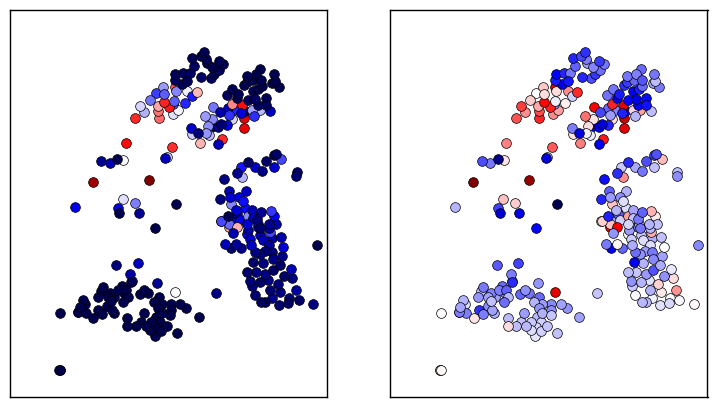

In [9]:
f1, ax = plt.subplots(ncols = 2, figsize=(9,5))
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
df.plot(column = 'n_rides', cmap = 'seismic', ax = ax[0], markersize = 7)
#df.plot(column = 'dist_tohom', cmap = 'seismic', ax = ax[1], markersize = 7)
df.plot(column = 'resid', cmap = 'seismic', ax = ax[1], markersize = 7)

In [10]:
# spatial regression

if not os.path.exists('data/for_sreg/'):
    os.makedirs('data/for_sreg/')
    
df.to_file('data/for_sreg/for_sreg.shp')

w = ps.knnW_from_shapefile('data/for_sreg/for_sreg.shp', k = 2)
sp_reg = ps.spreg.ML_Lag(df[['n_rides']].as_matrix(), df[['dist_towor', 'dist_tohom', 'dist_tohom2', \
                                                          'subway_dis', 'workers', 'residents']].as_matrix(), w = w)
print sp_reg.summary

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         275
Mean dependent var  :   6368.3236                Number of Variables   :           8
S.D. dependent var  :   8368.4579                Degrees of Freedom    :         267
Pseudo R-squared    :      0.4983
Spatial Pseudo R-squared:  0.4119
Sigma-square ML     :35160153.483                Log likelihood        :   -2787.172
S.E of regression   :    5929.600                Akaike info criterion :    5590.345
                                                 Schwarz criterion     :    5619.279

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/scipy/optimize/_minimize.py:599: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


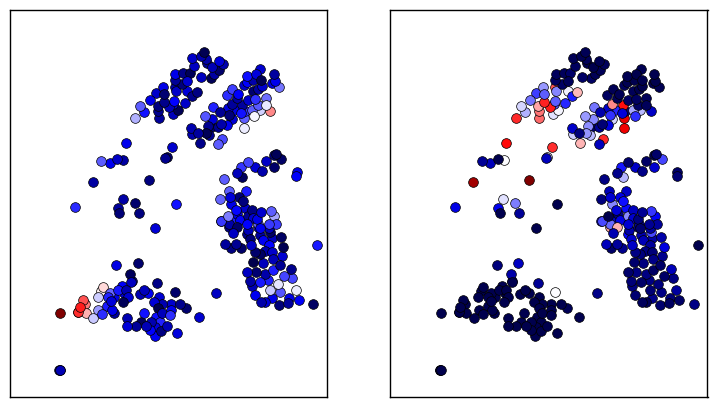

In [11]:
f1, ax = plt.subplots(ncols = 2, figsize=(9,5))
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
df.plot(column = 'subway_dis', cmap = 'seismic', ax = ax[0], markersize = 7)
df.plot(column = 'n_rides', cmap = 'seismic', ax = ax[1], markersize = 7)